# Семинар 11. PyTorch

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from torch import nn
from sklearn.datasets import load_boston

from tqdm.notebook import tqdm

%matplotlib inline

### 1. Pytorch и numpy 

Многие функции в pytorch очень напоминают numpy :)

In [14]:
a = np.random.rand(5, 3)
type(a)

numpy.ndarray

In [4]:
print(f"Размеры: {a.shape}")

Размеры: (5, 3)


In [5]:
print(f"Добавили 5:\n{a + 5}")

Добавили 5:
[[5.37810344 5.66108168 5.52828868]
 [5.27147654 5.04159665 5.95943735]
 [5.25727184 5.03912913 5.16954042]
 [5.28771682 5.62178844 5.11650595]
 [5.38911546 5.15983083 5.67303974]]


In [6]:
print(f"Посчитали произведение X X^T:\n{a @ a.T}")

Посчитали произведение X X^T:
[[0.85908013 0.63700489 0.2127092  0.58138844 0.60834641]
 [0.63700489 0.99594982 0.23413432 0.21575285 0.75802361]
 [0.2127092  0.23413432 0.09646384 0.11810394 0.22046994]
 [0.58138844 0.21575285 0.11810394 0.48297547 0.28974916]
 [0.60834641 0.75802361 0.22046994 0.28974916 0.62993924]]


In [7]:
print(f"Среднее по колонкам:\n{a.mean(axis=-1)}")

Среднее по колонкам:
[0.52249127 0.42417018 0.1553138  0.34200374 0.40732868]


In [8]:
print(f"Изменили размеры: {a.reshape(3, 5).shape}")

Изменили размеры: (3, 5)


Аналогичные операции в **pytorch** выглядят следующим образом:

In [9]:
x = torch.rand(5, 3)
x

tensor([[0.8444, 0.9712, 0.0435],
        [0.2654, 0.0884, 0.6404],
        [0.5513, 0.7718, 0.4210],
        [0.0539, 0.3135, 0.7251],
        [0.9067, 0.9680, 0.6299]])

In [10]:
print(f"Размеры: {x.shape}")

Размеры: torch.Size([5, 3])


In [17]:
x.numpy()

array([[0.8444488 , 0.9712072 , 0.04348814],
       [0.2654447 , 0.08840984, 0.6403858 ],
       [0.55128044, 0.7718269 , 0.42102575],
       [0.05388433, 0.31353796, 0.72514147],
       [0.90673643, 0.96797985, 0.62986445]], dtype=float32)

In [19]:
x.dtype

torch.float32

In [20]:
print(f"Добавили 5:\n{x + 5}")

Добавили 5:
tensor([[5.8444, 5.9712, 5.0435],
        [5.2654, 5.0884, 5.6404],
        [5.5513, 5.7718, 5.4210],
        [5.0539, 5.3135, 5.7251],
        [5.9067, 5.9680, 5.6299]])


In [21]:
# для перемножения тензоров высокой размерности читайте документацию по различным вариантам:
# torch.mm, torch.matmul, torch.bmm, @
print(f"X X^T  (1):\n{torch.matmul(x, x.transpose(1, 0))}\n")
print(f"X X^T  (2):\n{x.mm(x.t())}")

X X^T  (1):
tensor([[1.6582, 0.3379, 1.2334, 0.3815, 1.7332],
        [0.3379, 0.4884, 0.4842, 0.5064, 0.7296],
        [1.2334, 0.4842, 1.0769, 0.5770, 1.5122],
        [0.3815, 0.5064, 0.5770, 0.6270, 0.8091],
        [1.7332, 0.7296, 1.5122, 0.8091, 2.1559]])

X X^T  (2):
tensor([[1.6582, 0.3379, 1.2334, 0.3815, 1.7332],
        [0.3379, 0.4884, 0.4842, 0.5064, 0.7296],
        [1.2334, 0.4842, 1.0769, 0.5770, 1.5122],
        [0.3815, 0.5064, 0.5770, 0.6270, 0.8091],
        [1.7332, 0.7296, 1.5122, 0.8091, 2.1559]])


In [22]:
print(f"Среднее по колонкам:\n{x.mean(dim=-1)}")

Среднее по колонкам:
tensor([0.6197, 0.3314, 0.5814, 0.3642, 0.8349])


In [26]:
x

tensor([[0.8444, 0.9712, 0.0435],
        [0.2654, 0.0884, 0.6404],
        [0.5513, 0.7718, 0.4210],
        [0.0539, 0.3135, 0.7251],
        [0.9067, 0.9680, 0.6299]])

In [28]:
x.view([-1, 1])

tensor([[0.8444],
        [0.9712],
        [0.0435],
        [0.2654],
        [0.0884],
        [0.6404],
        [0.5513],
        [0.7718],
        [0.4210],
        [0.0539],
        [0.3135],
        [0.7251],
        [0.9067],
        [0.9680],
        [0.6299]])

In [25]:
print(f"Изменили размеры:\n{x.view([3, 5]).shape}\n")

# будьте внимательны и не используйте view для транспонирования осей
print(f"По-другому изменили размеры:\n{x.view_as(x.t()).shape}\n")
print(f"Но не транспонировали!\n{x.view_as(x.t()) == x.t()}")

Изменили размеры:
torch.Size([3, 5])

По-другому изменили размеры:
torch.Size([3, 5])

Но не транспонировали!
tensor([[ True, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True]])


Небольшой пример того, как меняются операции:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype("int64") -> x.type(torch.LongTensor)`

Для помощи вам есть [таблица](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users), которая поможет вам найти аналог операции в numpy


#### Разминка на pytorch

При помощи pytorch посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [32]:
torch.sum(torch.arange(1, 10001) ** 2)

tensor(333383335000)

### 2. Создаем тензоры в pytorch 

In [33]:
x = torch.empty(5, 3)  # пустой тензор
print(x)

tensor([[0.0000e+00, 1.5846e+29, 0.0000e+00],
        [1.5846e+29, 1.1210e-44, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4013e-45, 7.0295e+28, 6.1949e-04],
        [4.7429e+30, 1.3818e+31, 5.3377e+31]])


In [34]:
x = torch.rand(5, 3)  # случайный тензор
print(x)

tensor([[0.2146, 0.3160, 0.9169],
        [0.2386, 0.5740, 0.8383],
        [0.1427, 0.8986, 0.7265],
        [0.2938, 0.0813, 0.6957],
        [0.6665, 0.3423, 0.6385]])


In [35]:
x = torch.zeros(5, 3, dtype=torch.float32)  # тензор нулей с указанием типов чисел
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [36]:
x = torch.tensor([5.5, 3],  dtype=torch.double)  # конструируем тензор из питоновского листа
print(x)

tensor([5.5000, 3.0000], dtype=torch.float64)


In [37]:
x1 = x.new_ones(5, 3)  # используем уже созданный тензор для создания тензора из единичек
print(x1) 

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


In [39]:
x = torch.randn_like(x1, dtype=torch.float)  # создаем случайный тензор с размерами x
print(x, x.size())

tensor([[-0.8156,  0.1749,  0.5821],
        [ 0.1628, -0.0145, -0.4871],
        [ 0.0417, -1.0388,  0.3905],
        [ 0.9594,  1.4411, -1.4257],
        [ 0.2633, -0.2703, -0.9109]]) torch.Size([5, 3])


In [40]:
y = torch.rand(5, 3)
print(x + y)  # операция сложения

tensor([[-0.3308,  0.6407,  1.1267],
        [ 0.3548,  0.4452,  0.3569],
        [ 0.7661, -0.7498,  0.6223],
        [ 1.7688,  1.5595, -0.5984],
        [ 1.0422, -0.0623, -0.6761]])


In [41]:
z = torch.add(x, y)  # очередная операция сложения
print(z)

tensor([[-0.3308,  0.6407,  1.1267],
        [ 0.3548,  0.4452,  0.3569],
        [ 0.7661, -0.7498,  0.6223],
        [ 1.7688,  1.5595, -0.5984],
        [ 1.0422, -0.0623, -0.6761]])


In [47]:
d = torch.tensor(9.0)

In [51]:
torch.add(x, y, out=d)  # и наконец последний вид

tensor([[-0.3308,  0.6407,  1.1267],
        [ 0.3548,  0.4452,  0.3569],
        [ 0.7661, -0.7498,  0.6223],
        [ 1.7688,  1.5595, -0.5984],
        [ 1.0422, -0.0623, -0.6761]])

In [52]:
print(x * y)  # поэлементное умножение

tensor([[-0.3954,  0.0815,  0.3170],
        [ 0.0313, -0.0067, -0.4111],
        [ 0.0302, -0.3002,  0.0905],
        [ 0.7765,  0.1706, -1.1795],
        [ 0.2051, -0.0562, -0.2138]])


In [53]:
x.unsqueeze(0)

tensor([[[-0.8156,  0.1749,  0.5821],
         [ 0.1628, -0.0145, -0.4871],
         [ 0.0417, -1.0388,  0.3905],
         [ 0.9594,  1.4411, -1.4257],
         [ 0.2633, -0.2703, -0.9109]]])

In [59]:
x_new = x.unsqueeze(0)  # добавили измерение в начало, аналог броадкастинга

In [57]:
x.unsqueeze(0).unsqueeze(1).squeeze().shape

torch.Size([5, 3])

In [ ]:
print(x.unsqueeze(0).unsqueeze(1).squeeze().shape)  # убрали измерение в начале

Мы также можем делать обычные срезы и переводить матрицы назад в numpy:

In [58]:
a = np.ones((3, 5))
x = torch.ones((3, 5))
print(np.allclose(x.numpy(), a))
print(np.allclose(x.numpy()[:, 1], a[:, 1]))

True
True


### 3. Работаем с градиентами 

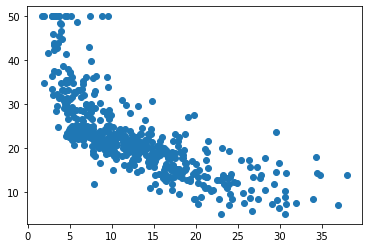

In [66]:
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target);

В pytorch есть возможность при создании тензора указывать нужно ли считать по нему градиент или нет, с помощью параметра `requires_grad`. Когда `requires_grad=True` мы сообщаем фреймворку, о том, что мы хотим следить за всеми тензорами, которые получаются из созданного. Иными словами, у любого тензора, у которого указан данный параметр, будет доступ к цепочке операций и преобразований совершенными с ними. Если эти функции дифференцируемые, то у тензора появляется параметр `.grad`, в котором хранится значение градиента.

Если к результирующему тензору применить метод `.backward()`, то фреймворк посчитает по цепочке градиент для всех тензоров, у которых `requires_grad=True`.

In [114]:
a = torch.tensor([1., 2.], requires_grad=True, dtype=torch.float64)

In [115]:
l = torch.sum(a ** 2)

In [116]:
l.backward()

In [117]:
a.zero_

<function Tensor.zero_>

In [123]:
type(a.grad)

torch.Tensor

In [111]:
a.grad.data

tensor([0., 0.])

In [109]:
a.grad

tensor([0., 0.])

In [142]:
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

In [153]:
w = torch.rand(1, requires_grad=True)
w2 = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / boston.data[:, -1].max(), dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

# только создали тензоры и в них нет градиентов
assert w.grad is None
assert b.grad is None

In [144]:
y_pred = w * x + b                    # и опять совершаем операции с тензорами
loss = torch.mean((y_pred - y) ** 2)  # совершаем операции с тензорами
loss.backward()                       # считаем градиенты

In [145]:
torch.mean(2 *(y_pred - y) * x)

tensor(-12.3253, grad_fn=<MeanBackward0>)

In [147]:
torch.mean(2 *(y_pred - y))

tensor(-44.6322, grad_fn=<MeanBackward0>)

In [146]:
# сделали операции и посчитали градиенты
assert w.grad is not None
assert b.grad is not None

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

dL/dw = 
 tensor([-12.3253])
dL/db = 
 tensor([-44.6322])


Для доступа к значениям в тензоре используйте атрибут `.data`:

In [149]:
w.data

tensor([0.0147])

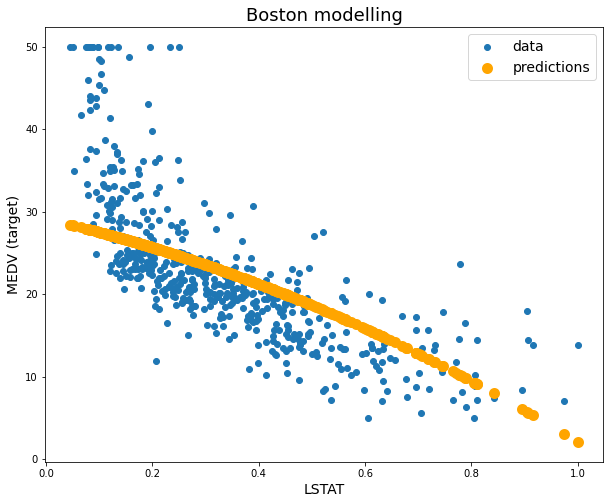

loss =  46.289146


In [154]:
from IPython.display import clear_output

for i in range(300):
    y_pred = w * x + w2 * x ** 2 + b
    # попробуйте сделать полиномиальную регрессию в данном предсказании и посчитать градиенты после
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    # делаем шаг градиентного спуска с lr = .05
    w.data -=  0.05 * w.grad# YOUR CODE
    w2.data -= 0.05 * w2.grad
    b.data -=  0.05 * b.grad# YOUR CODE

    # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
    w.grad.zero_()
    w2.grad.zero_()
    b.grad.zero_()

    # рисуем картинки
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(x.data.numpy(), y.data.numpy(), label="data")
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color="orange", linewidth=5, label="predictions")
        plt.xlabel("LSTAT", fontsize=14)
        plt.ylabel("MEDV (target)", fontsize=14)
        plt.title("Boston modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.1:
            print("Done!")
            break


### 4. Нейросетки


![nn](nn.png)
![non_linear](active.png)
![активации](activation.png)

https://www.youtube.com/watch?v=Ilg3gGewQ5U

Для того, чтобы разобраться как обучать нейросите в pytorch, нужно освоить три вещи: 

1. Как формировать батчи и передавать их сетке
2. Как написать модель 
3. Как написать цикл обучения и отслеживать метрики

#### Dataset API

В Pytorch работа с данными строится на двух классах из [torch.utils.data](https://pytorch.org/docs/stable/data.html): `Dataset` и `DataLoader`:

- `Dataset` отвечает за подготовку одного примера
- `DataLoader` отвечает за выбор примеров, склейку их в один батч и распараллеливание на CPU, поддерживает итерирование.


Для решения задачи обычно пишут кастомные Dataset-классы, для этого нужно написать всего две функции:
- `.__len__(self)` возвращает количество примеров в датасете;
- `.__getitem__(self, item)` возвращает item-ный по счету пример из датасета.

Задачи DataLoader достаточно сложно аккуратно реализовать и лучше использовать готовый. Он довольно гибкий, все основные моменты кастомизируются заданием функций:
```
torch.utils.data.DataLoader(
    dataset,            # собственно экземпляр класса Dataset, из которого надо доставать примеры
    batch_size=1,       # количество примеров в батче
    drop_last=False,    # нужно ли при итерировании выбрасывать неполные батчи? (такое бывает, если число примеров не делится нацело на batch_size
    shuffle=False,      # перемешивать ли примеры
    sampler=None,       # чтобы перемешивать примеры кастомно
    batch_sampler=None, # чтобы использовать кастомный отбор примеров в батч
    num_workers=0,      # на сколько процессов запараллелить подготовку данных
    collate_fn=None,    # функция, которая будет склеивать примеры в батчи
    # остальные аргументы более технические, сейчас можно не рассматривать
    pin_memory=False,   
    timeout=0, 
    worker_init_fn=None, 
    multiprocessing_context=None, 
    generator=None)
```
Теперь давайте напишем такой сами, в качестве датасета сгенерируем рандомные данные.

In [185]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ind):
        return dict(
                   sample=self.x[ind].astype(np.float32),
                   label=y[ind].astype(np.float32)
                   )
        

In [159]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [184]:
x[10].astype(np.float32)

array([0.6213548 , 0.48573378, 0.4694365 , 0.47169033, 0.8067062 ],
      dtype=float32)

In [186]:
our_dataset = RandomDataset(x, y)

In [187]:
len(our_dataset)

1000

In [188]:
our_dataset[0]

{'sample': array([0.72203386, 0.2934182 , 0.6996042 , 0.2852677 , 0.6153764 ],
       dtype=float32),
 'label': 0.74431115}

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как даталоадер, который принимает на вход класс унаследованный от `torch.utils.data.Dataset`. Сейчас посмотрим на пример:

In [189]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

In [190]:
next(iter(dataloader))

{'sample': tensor([[0.7220, 0.2934, 0.6996, 0.2853, 0.6154],
         [0.2920, 0.7166, 0.1111, 0.5875, 0.3061],
         [0.5366, 0.7060, 0.8019, 0.5282, 0.9789],
         [0.4923, 0.4442, 0.2957, 0.6330, 0.6231]]),
 'label': tensor([0.7443, 0.0719, 0.2220, 0.3822])}

Работают с ним следующим образом:

In [191]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['label']}")

Sample:
tensor([[0.7220, 0.2934, 0.6996, 0.2853, 0.6154],
        [0.2920, 0.7166, 0.1111, 0.5875, 0.3061],
        [0.5366, 0.7060, 0.8019, 0.5282, 0.9789],
        [0.4923, 0.4442, 0.2957, 0.6330, 0.6231]])
Target:
tensor([0.7443, 0.0719, 0.2220, 0.3822])


#### Как сделать нейросеть

Пример как это может выглядеть:

In [192]:
model = nn.Sequential()                   # создаем пустую модель, в которую будем добавлять слои
model.add_module("l1", nn.Linear(5, 10))  # добавили слой с 5-ю нейронами на вход 
model.add_module("l2", nn.ReLU())         # добавили функцию активации
model.add_module("l3", nn.Linear(10, 1)) 

# альтернативный способ
another_model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [193]:
y_pred = another_model(batch['sample']) # получили предсказания модели

In [196]:
batch

{'sample': tensor([[0.7220, 0.2934, 0.6996, 0.2853, 0.6154],
         [0.2920, 0.7166, 0.1111, 0.5875, 0.3061],
         [0.5366, 0.7060, 0.8019, 0.5282, 0.9789],
         [0.4923, 0.4442, 0.2957, 0.6330, 0.6231]]),
 'label': tensor([0.7443, 0.0719, 0.2220, 0.3822])}

In [195]:
y_pred

tensor([[-0.3404],
        [-0.4224],
        [-0.4833],
        [-0.4221]], grad_fn=<AddmmBackward0>)

Может быть удобно сделать в виде класса. Нейросеть должна быть унаследована от класса `nn.Module`.

In [197]:
nn.Module??

In [198]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                nn.Linear(5, 10),
                nn.ReLU(),
                nn.Linear(10, 25),
                nn.ReLU()
                )
        self.predict = nn.Linear(25, 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = self.predict(x)
        return x

In [200]:
model = MyModel()
model

MyModel(
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=25, bias=True)
    (3): ReLU()
  )
  (predict): Linear(in_features=25, out_features=1, bias=True)
)

#### Как написать цикл обучения и отслеживать метрики
 
Давайте соберем загрузку данных, создание модели и обучим на мнисте.

In [201]:
from torchvision import transforms

In [202]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
) 
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



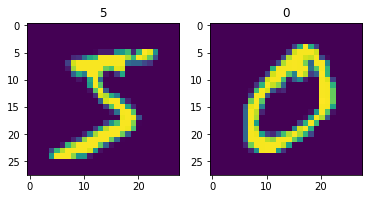

In [210]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [211]:
model = nn.Sequential(
    nn.Flatten(),             # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(28 * 28, 128),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),                # нелинейность
    nn.Linear(128, 10),       # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

# создаем оптимизатор, который будет обновлять веса модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

In [214]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[-2.8541e-02, -9.7608e-03, -2.0172e-02,  ...,  2.0344e-03,
          1.9991e-02, -9.4855e-03],
        [-2.1898e-02, -2.1929e-03, -1.3267e-02,  ..., -2.1947e-03,
          1.9249e-02, -1.0346e-02],
        [-4.4271e-03,  1.5452e-02,  7.6904e-03,  ..., -1.4754e-02,
         -1.0662e-03, -5.0564e-03],
        ...,
        [-1.8913e-02, -5.1831e-03, -2.2837e-04,  ...,  3.3752e-02,
         -3.0041e-02,  1.4917e-02],
        [-3.0654e-02,  1.2459e-02, -2.1263e-02,  ..., -1.3027e-02,
          2.1879e-02,  2.3969e-02],
        [-4.9043e-05,  1.5692e-02, -2.2420e-02,  ..., -2.8421e-02,
         -6.9332e-03, -2.1500e-03]], requires_grad=True)
Parameter containing:
tensor([-0.0198,  0.0329,  0.0284,  0.0139, -0.0017, -0.0217,  0.0033,  0.0303,
         0.0019,  0.0250,  0.0038, -0.0253, -0.0251,  0.0264,  0.0183, -0.0063,
        -0.0324, -0.0139, -0.0029, -0.0347, -0.0240,  0.0303, -0.0120,  0.0074,
        -0.0185,  0.0073,  0.0022,  0.0271, -0.0196, -0.0244, -0

Веса моделей хранятся в виде матриц и выглядят так:

[Красиво](https://wandb.ai/wandb/getting-started/reports/Visualize-Debug-Machine-Learning-Models--VmlldzoyNzY5MDk) трекать метрики в полуавтоматическом режиме можно в [wandb](https://wandb.ai). Для этого регистрируемся на сайте, устанавливаем и логинимся(это того стоит):

In [216]:
!pip install wandb --upgrade --quiet
import wandb

# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
wandb.login()

config = dict(model = 'Fully connected nn',
             learning_rate = 0.05,
             data = 'MNIST')

# инициализируем проект
wandb.init(project="pytorch-d|emo",
           notes="my first model in pytorch",
           config=config)
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[]

Можно перейти по ссылке и следить за нашей моделью прямо во время обучения!

In [217]:
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):    # берем батч из трейн лоадера
        y_pred = model(x_train)                        # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)        # считаем лосс
        loss.backward()                                # считаем градиенты обратным проходом
        optimizer.step()                               # обновляем параметры сети
        optimizer.zero_grad()                          # обнуляем посчитанные градиенты параметров
        
        wandb.log({"train loss": loss})
    
    if epoch % 2 == 0:
        val_loss = []                                  # сюда будем складывать **средний по батчу** лосс
        val_accuracy = []
        with torch.no_grad():                          # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):  # берем батч из вал лоадера
                y_pred = model(x_val)                  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.numpy())          # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
          
        # логируем метрики
        wandb.log({"mean val loss": np.mean(val_loss),
                   "mean val accuracy": np.mean(val_accuracy)})
        
        # печатаем метрики
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.15456828474998474, accuracy: 0.9525


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08225107938051224, accuracy: 0.9757


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.07447724789381027, accuracy: 0.9772


### Оптимизаторы


Чаще всего вам будут встречаться такие.


Вот [здесь](https://habr.com/ru/post/318970/) норм объяснили.



Идея методов с инерцией: «Если мы некоторое время движемся в определённом направлении, то, вероятно, нам следует туда двигаться некоторое время и в будущем».

Идея методов с масштабирование градиента: «Если мы слишком сильно обновляли какие-то параметры в прошлом, возможно, в будущем стоит обратить больше внимания на те параметры, которые мы обновляли мало».


!['modes'](modifications.png)

In [ ]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

Основные функции PyTorch Optimizer:

- step - обновление весов модели
- zero_grad - занулить веса модели (по умолчанию градиенты в PyTorch аккумулируются) ~ ```for each param in params: param.grad = None```
- state_dict - получить текущее состояние Optimizer. Для адаптивных методов тут будут храниться аккумулированные квадраты градиентов

#### Делаем свой Optimizer

Для того чтобы сделать свой Optimizer, не нужно писать свою имплементацию каждой из основных функций. Достаточно переопределить только одну из них - step.

Попробуем реализовать AdaGrad. 

Алгоритм следующий:

$g_t = \nabla_{w} L(w_t)$

$G_t = G_{t-1} + g_t^2$

$w_{t} = w_{t-1} - \frac{\eta}{\sqrt{G_t + \epsilon}} g_t$



В качестве данных для модели воспользуемся make_regression из sklearn.

In [ ]:
import random
import os

from sklearn.datasets import make_regression

def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )


In [ ]:
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform a single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

In [ ]:
class Adagrad(InClassOptimizer):
    def __init__(self, params, lr=0.01, eps=1e-13):
        defaults = dict(lr=lr, eps=eps)
        super().__init__(params, defaults)
        

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group["lr"]
        eps = group["eps"]
        for param in filter(lambda x: x.grad is not None, group["params"]):
            pass
            # TODO:
            # Your code here
            # --------------
            # --------------

    def _get_adagrad_buffer(self, param):
        """
        Get accumulated gradients for Adagrad.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adagrad gradients for parameter.
        """
        param_state = self.state[param]
        
        return param_state["adagrad_buffer"]

    def _init_adagrad_buffer(self, param):
        """
        Initialize accumulated gradeints for SGD momentum.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.
        """
        param_state = self.state[param]
        if "adagrad_buffer" not in param_state:
            param_state["adagrad_buffer"] = torch.zeros_like(param)

Чекер, что все ок.

In [ ]:
def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f"Iteration {i} loss: {output.item()}")

In [ ]:
model = get_model()
optim = Adagrad(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

In [ ]:
model = get_model()
optim = torch.optim.Adagrad(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

**Sources**: 
- https://github.com/hse-ds/iad-deep-learning/tree/master/2021/seminars
- https://github.com/m12sl/dl-hse-2021/blob/main/02-pytorch/seminar.ipynb
- https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf (еще больше красивых картинок)